In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import scipy.cluster.hierarchy as sch
import pingouin as pg
from statsmodels.stats.multicomp import MultiComparison, pairwise_tukeyhsd
import statsmodels.formula.api as smfa
from statsmodels.stats.anova import anova_lm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.sandbox.stats.runs import runstest_1samp
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import calinski_harabasz_score
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics.cluster import adjusted_rand_score

In [3]:
cats_df = pd.read_csv('data/cats.csv')
cats_df.head()

,Sex,Bwt,Hwt
0,F,2.0,7.0
1,F,2.0,7.4
2,F,2.0,9.5
3,F,2.1,7.2
4,F,2.1,7.3


In [4]:
mu = 2.6
ss.shapiro(cats_df['Bwt']), ss.shapiro(cats_df['Hwt'])

(ShapiroResult(statistic=0.9518786668777466, pvalue=6.730248423991725e-05),
 ShapiroResult(statistic=0.9603861570358276, pvalue=0.0003653781022876501))

In [5]:
ss.wilcoxon(cats_df['Bwt'] - mu, alternative='two-sided')

WilcoxonResult(statistic=3573.0, pvalue=0.02524520294814093)

In [6]:
ss.ttest_1samp(cats_df['Bwt'], popmean=mu)

Ttest_1sampResult(statistic=3.0564867998078107, pvalue=0.0026730362561723613)

In [7]:
data = {'before':[7,3,4,5,2,1,6,6,5,4],
       'after':[8,4,5,6,2,3,6,8,6,5]}
data_df = pd.DataFrame(data)
data_df.head()

,before,after
0,7,8
1,3,4
2,4,5
3,5,6
4,2,2


In [8]:
ss.shapiro(data_df['after'] - data_df['before'])

ShapiroResult(statistic=0.8148398399353027, pvalue=0.021947871893644333)

In [9]:
ss.ttest_rel(data_df['after'], data_df['before'], alternative='greater')

Ttest_relResult(statistic=4.743416490252569, pvalue=0.0005269356285082764)

In [10]:
female = cats_df.loc[cats_df['Sex'] == 'F', 'Bwt']
male = cats_df.loc[cats_df['Sex'] == 'M', 'Bwt']

In [11]:
ss.levene(female, male)

LeveneResult(statistic=19.43101190877999, pvalue=2.0435285255189404e-05)

In [12]:
ss.ttest_ind(female, male, equal_var=False, alternative='two-sided')

Ttest_indResult(statistic=-8.70948849909559, pvalue=8.831034455859356e-15)

<AxesSubplot:>

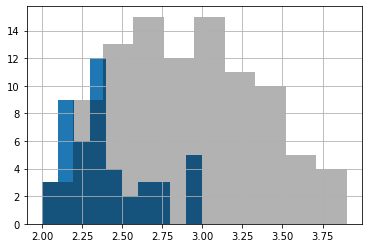

In [13]:
female.hist()
male.hist(color='black', alpha=0.3)

In [14]:
iris_df = pd.read_csv('data/iris.csv')
iris_df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [15]:
target_list = iris_df['target'].unique()
setosa = iris_df.loc[iris_df['target'] == 'Iris-setosa', 'sepal width']
versicolor = iris_df.loc[iris_df['target'] == 'Iris-versicolor', 'sepal width']
virginica = iris_df.loc[iris_df['target'] == 'Iris-virginica', 'sepal width']

In [16]:
ss.shapiro(setosa), ss.shapiro(versicolor), ss.shapiro(virginica)

(ShapiroResult(statistic=0.968691885471344, pvalue=0.20465604960918427),
 ShapiroResult(statistic=0.9741330742835999, pvalue=0.33798879384994507),
 ShapiroResult(statistic=0.9673910140991211, pvalue=0.1809043288230896))

In [17]:
ss.levene(setosa, versicolor, virginica)

LeveneResult(statistic=0.6475222363405327, pvalue=0.5248269975064537)

In [18]:
ss.f_oneway(setosa, versicolor, virginica)

F_onewayResult(statistic=47.36446140299382, pvalue=1.3279165184572242e-16)

In [19]:
mc = MultiComparison(data=iris_df['sepal width'], groups=iris_df['target'])
tukey = mc.tukeyhsd(alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Iris-setosa,Iris-versicolor,-0.648,0.0,-0.8092,-0.4868,True
Iris-setosa,Iris-virginica,-0.444,0.0,-0.6052,-0.2828,True
Iris-versicolor,Iris-virginica,0.204,0.009,0.0428,0.3652,True


In [20]:
ss.kruskal(setosa, versicolor, virginica)

KruskalResult(statistic=62.49463010053111, pvalue=2.6882119006774528e-14)

In [21]:
pg.welch_anova(data=iris_df, dv='sepal width', between='target')

,Source,ddof1,ddof2,F,p-unc,np2
0,target,2,97.369597,43.303381,3.519723e-14,0.391881


In [22]:
mt_df = pd.read_csv('data/mtcars.csv')
mt_df.head()

,Unnamed: 0,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2


In [23]:
formula = 'mpg ~ C(am) + C(cyl) + C(am):C(cyl)'
model = smfa.ols(formula, mt_df).fit()
aov_table = anova_lm(model, typ=2)
aov_table.round(3)

,sum_sq,df,F,PR(>F)
C(am),36.767,1.0,3.999,0.056
C(cyl),456.401,2.0,24.819,0.000
C(am):C(cyl),25.437,2.0,1.383,0.269
Residual,239.059,26.0,NaN,NaN


In [24]:
mc = MultiComparison(data=mt_df['mpg'], groups=mt_df['cyl'])
tukey = mc.tukeyhsd(alpha=0.05)
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
4,6,-6.9208,0.0003,-10.7693,-3.0722,True
4,8,-11.5636,0.0,-14.7708,-8.3565,True
6,8,-4.6429,0.0112,-8.3276,-0.9581,True


In [25]:
tit_df = pd.read_csv('data/titanic.csv')
obs = tit_df[tit_df['survived'] == 1]['sex'].value_counts().reindex(['female', 'male'])
exp = tit_df['sex'].value_counts(normalize=True).reindex(['female', 'male']).mul(obs.sum())
obs, exp

(female    233
 male      109
 Name: sex, dtype: int64,
 female    120.525253
 male      221.474747
 Name: sex, dtype: float64)

In [26]:
ss.chisquare(f_obs=obs, f_exp=exp)

Power_divergenceResult(statistic=162.08166685161612, pvalue=3.970516389658729e-37)

In [27]:
table = pd.crosstab(tit_df['class'], tit_df['survived'])
table

survived,0,1
class,,
First,80,136
Second,97,87
Third,372,119


In [28]:
chi, p, ddof, f_exp = ss.chi2_contingency(observed=table)
chi, p, ddof, f_exp

(102.88898875696056,
 4.549251711298793e-23,
 2,
 array([[133.09090909,  82.90909091],
        [113.37373737,  70.62626263],
        [302.53535354, 188.46464646]]))

In [29]:
house_df = pd.read_csv('data/kc_house_data.csv')
house_df[['price', 'sqft_living']].corr()

,price,sqft_living
price,1.000000,0.702035
sqft_living,0.702035,1.000000


In [30]:
formula = 'price ~ sqft_living'
model = smfa.ols(formula, data=house_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.100e+04
Date:                Tue, 15 Nov 2022   Prob (F-statistic):               0.00
Time:                        22:00:11   Log-Likelihood:            -3.0027e+05
No. Observations:               21613   AIC:                         6.005e+05
Df Residuals:                   21611   BIC:                         6.006e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.358e+04   4402.690     -9.899      0.000   -5.22e+04    -3.5e+04
sqft_living   280.6236      1.936    144.920      0.000     276.828     284.419
==============================================================================
Omnibus:                    14832.490   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           546444.713
Skew:                           2.824   Prob(JB):                         0.00
Kurtosis:                      26.977   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

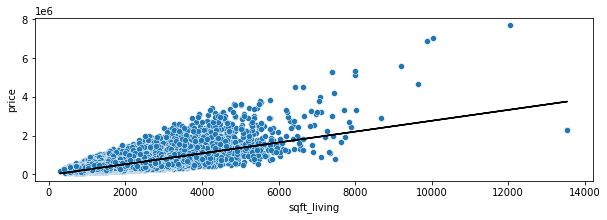

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
sns.scatterplot(data=house_df, x='sqft_living', y='price', ax=ax)
ax.plot(house_df['sqft_living'], model.predict(house_df['sqft_living']), color='black')

In [32]:
car_df = pd.read_csv('data/Cars93.csv')
car_df.columns = car_df.columns.str.replace('.', '')
car_df.head()

C:\Users\admin\AppData\Local\Temp\ipykernel_5988\1094043285.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  car_df.columns = car_df.columns.str.replace('.', '')


,Manufacturer,Model,Type,MinPrice,Price,MaxPrice,MPGcity,MPGhighway,AirBags,DriveTrain,...,Passengers,Length,Wheelbase,Width,Turncircle,Rearseatroom,Luggageroom,Weight,Origin,Make
0,Acura,Integra,Small,12.9,15.9,18.8,25,31,None,Front,...,5,177,102,68,37,26.5,11,2705,non-USA,Acura Integra
1,Acura,Legend,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,Front,...,5,195,115,71,38,30.0,15,3560,non-USA,Acura Legend
2,Audi,90,Compact,25.9,29.1,32.3,20,26,Driver only,Front,...,5,180,102,67,37,28.0,14,3375,non-USA,Audi 90
3,Audi,100,Midsize,30.8,37.7,44.6,19,26,Driver & Passenger,Front,...,6,193,106,70,37,31.0,17,3405,non-USA,Audi 100
4,BMW,535i,Midsize,23.7,30.0,36.2,22,30,Driver only,Rear,...,4,186,109,69,39,27.0,13,3640,non-USA,BMW 535i


In [33]:
ind_var = ['EngineSize', 'RPM', 'Weight', 'Length', 'MPGcity', 'MPGhighway']
model = smfa.ols('Price ~ EngineSize + RPM + Weight + Length + MPGcity + MPGhighway', data=car_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     19.14
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           4.88e-14
Time:                        22:00:12   Log-Likelihood:                -302.94
No. Observations:                  93   AIC:                             619.9
Df Residuals:                      86   BIC:                             637.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -32.2157     17.812     -1.809      0.074     -67.625       3.193
EngineSize     4.4732      1.410      3.172      0.002       1.670       7.276
RPM            0.0071      0.001      5.138      0.000       0.004       0.010
Weight         0.0056      0.003      1.634      0.106      -0.001       0.012
Length        -0.0464      0.094     -0.496      0.621      -0.232       0.139
MPGcity       -0.3478      0.448     -0.776      0.440      -1.239       0.544
MPGhighway     0.0582      0.460      0.126      0.900      -0.856       0.973
==============================================================================
Omnibus:                       62.984   Durbin-Watson:                   1.446
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              383.289
Skew:                           2.074   Prob(JB):                     5.89e-84
Kurtosis:                      12.039   Cond. No.                     1.61e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
car_df[ind_var].corr()

,EngineSize,RPM,Weight,Length,MPGcity,MPGhighway
EngineSize,1.000000,-0.547898,0.845075,0.780283,-0.710003,-0.626795
RPM,-0.547898,1.000000,-0.427931,-0.441249,0.363045,0.313469
Weight,0.845075,-0.427931,1.000000,0.806274,-0.843139,-0.810658
Length,0.780283,-0.441249,0.806274,1.000000,-0.666239,-0.542897
MPGcity,-0.710003,0.363045,-0.843139,-0.666239,1.000000,0.943936
MPGhighway,-0.626795,0.313469,-0.810658,-0.542897,0.943936,1.000000


In [35]:
y, X = dmatrices('Price ~ EngineSize + RPM + Weight + Length + MPGcity + MPGhighway', data=car_df, return_type='dataframe')

In [36]:
vif_list = []
for i in range(1, len(X.columns)):
    vif_list.append([variance_inflation_factor(X.values, i), X.columns[i]])
pd.DataFrame(vif_list, columns=['vif', 'variable'])

,vif,variable
0,4.605118,EngineSize
1,1.446859,RPM
2,8.685973,Weight
3,4.013002,Length
4,13.668288,MPGcity
5,12.943133,MPGhighway


In [37]:
model = smfa.ols('Price ~ EngineSize + RPM + Weight + MPGhighway', data=car_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     28.98
Date:                Tue, 15 Nov 2022   Prob (F-statistic):           2.26e-15
Time:                        22:00:12   Log-Likelihood:                -303.29
No. Observations:                  93   AIC:                             616.6
Df Residuals:                      88   BIC:                             629.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -37.7063     14.846     -2.540      0.013     -67.210      -8.203
EngineSize     4.5884      1.343      3.418      0.001       1.920       7.256
RPM            0.0071      0.001      5.232      0.000       0.004       0.010
Weight         0.0049      0.003      1.690      0.095      -0.001       0.011
MPGhighway    -0.2646      0.221     -1.200      0.234      -0.703       0.174
==============================================================================
Omnibus:                       62.072   Durbin-Watson:                   1.398
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              368.013
Skew:                           2.047   Prob(JB):                     1.22e-80
Kurtosis:                      11.843   Cond. No.                     1.35e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
us_df = pd.read_csv('data/USArrests.csv')
us_df = us_df.rename({'Unnamed: 0':'State'}, axis=1)
us_df.head()

,State,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


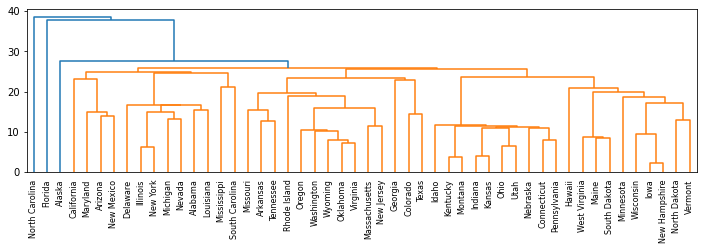

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(12,3))
single = sch.linkage(us_df.iloc[:, 1:], method='single', metric='euclidean')
sch.dendrogram(single, labels=us_df['State'].tolist())
plt.show()

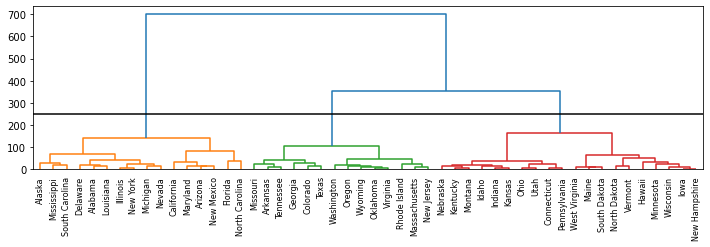

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(12,3))
ward = sch.linkage(us_df.iloc[:, 1:], method='ward', metric='euclidean')
sch.dendrogram(ward, labels = us_df['State'].tolist(), color_threshold=250)
plt.axhline(250, color='k')
plt.show()

In [41]:
assignments = sch.fcluster(ward, 250, criterion='distance')
assignments

array([1, 1, 1, 2, 1, 2, 3, 1, 1, 2, 3, 3, 1, 3, 3, 3, 3, 1, 3, 1, 2, 1,
       3, 1, 2, 3, 3, 1, 3, 2, 1, 1, 1, 3, 3, 2, 2, 3, 2, 1, 3, 2, 2, 3,
       3, 2, 2, 3, 3, 2], dtype=int32)

In [42]:
iris_df.head()

,sepal length,sepal width,petal length,petal width,target
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [43]:
X = iris_df.drop('target', axis=1)

In [44]:
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    labels = kmeans.labels_
    print(k, calinski_harabasz_score(X, labels))

2 513.3038433517568
3 560.3999242466402
4 529.3982941434156
5 493.79768982240194
6 474.85419152314864
7 450.7495385397598
8 439.1031541731567
9 413.3561290351985


c:\Users\admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


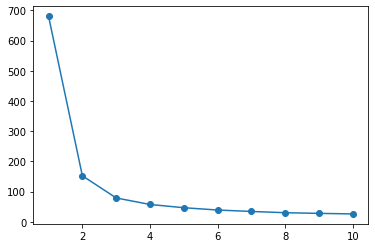

In [45]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    inertia.append(kmeans.inertia_)
plt.plot(range(1, 11), inertia, marker='o')

In [46]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
kmeans.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0])

In [47]:
iris_df['cluster'] = kmeans.labels_
iris_df.groupby(['cluster']).mean()

,sepal length,sepal width,petal length,petal width
cluster,,,,
0,5.901613,2.748387,4.393548,1.433871
1,5.006000,3.418000,1.464000,0.244000
2,6.850000,3.073684,5.742105,2.071053


In [48]:
formula = 'sepal_length ~ C(cluster)'
model = smfa.ols(formula, data=iris_df.rename({'sepal length':'sepal_length'}, axis=1)).fit()
aov_table = anova_lm(model, typ=1)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
C(cluster),2.0,73.775295,36.887647,190.979353,1.337593e-41
Residual,147.0,28.393039,0.193150,NaN,NaN


In [49]:
iris_df = iris_df.drop('cluster', axis=1)

In [50]:
pipe = make_pipeline(GaussianMixture(n_components=3, max_iter=1000)).fit(X)
pipe.predict(X)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [51]:
X_sc = StandardScaler().fit_transform(X)
gm = GaussianMixture(n_components=3, max_iter=1000).fit(X_sc)
gm.predict(X_sc)

array([2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 0,
       2, 0, 0, 2, 0, 2, 2, 2, 2, 0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0,
       0, 2, 0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [52]:
adjusted_rand_score(pipe.predict(X), gm.predict(X_sc))

0.4611040495874699

In [53]:
data = ['a','a','b','b','a','a','a','a','b','b','b','b','b','a','a','b','b','a','b','b']
test_df = pd.DataFrame(data, columns=['product'])
test_df['product'] = test_df['product'].replace({'a':1, 'b':0})
test_df.head()

,product
0,1
1,1
2,0
3,0
4,1


In [56]:
runstest_1samp(test_df, cutoff='mean', correction=0.5)

(-1.1144881152070183, 0.26506984027306035)

In [62]:
dataset = [['Apple', 'Beer', 'Rice', 'Chicken'],
           ['Apple', 'Beer', 'Rice'],
           ['Apple', 'Beer'],
           ['Apple', 'Bananas'],
           ['Milk', 'Beer', 'Rice', 'Chicken'],
           ['Milk', 'Beer', 'Rice'],
           ['Milk', 'Beer'],
           ['Apple', 'Bananas']]
te = TransactionEncoder().fit(dataset)
te_ary = te.transform(dataset)
te_ary, te.columns_

(array([[ True, False,  True,  True, False,  True],
        [ True, False,  True, False, False,  True],
        [ True, False,  True, False, False, False],
        [ True,  True, False, False, False, False],
        [False, False,  True,  True,  True,  True],
        [False, False,  True, False,  True,  True],
        [False, False,  True, False,  True, False],
        [ True,  True, False, False, False, False]]),
 ['Apple', 'Bananas', 'Beer', 'Chicken', 'Milk', 'Rice'])

In [63]:
ar_df = pd.DataFrame(te_ary, columns=te.columns_)
ar_df.head()

,Apple,Bananas,Beer,Chicken,Milk,Rice
0,True,False,True,True,False,True
1,True,False,True,False,False,True
2,True,False,True,False,False,False
3,True,True,False,False,False,False
4,False,False,True,True,True,True


In [68]:
freq_items = apriori(ar_df, min_support=0.3, use_colnames=True)
freq_items['length'] = freq_items['itemsets'].apply(lambda df: len(df))
freq_items

,support,itemsets,length
0,0.625,(Apple),1
1,0.750,(Beer),1
2,0.375,(Milk),1
3,0.500,(Rice),1
4,0.375,"(Beer, Apple)",2
5,0.375,"(Beer, Milk)",2
6,0.500,"(Beer, Rice)",2


In [69]:
gro_df = pd.read_csv('data/groceries.csv', names=['food'])
df_split_ary = gro_df['food'].str.split(',', expand=True).values
df_split_ary

array([['citrus fruit', 'semi-finished bread', 'margarine', ..., None,
        None, None],
       ['tropical fruit', 'yogurt', 'coffee', ..., None, None, None],
       ['whole milk', None, None, ..., None, None, None],
       ...,
       ['chicken', 'citrus fruit', 'other vegetables', ..., None, None,
        None],
       ['semi-finished bread', 'bottled water', 'soda', ..., None, None,
        None],
       ['chicken', 'tropical fruit', 'other vegetables', ..., None, None,
        None]], dtype=object)

In [71]:
groceries = []
for i in range(len(df_split_ary)):
    temp = list(filter(None, df_split_ary[i]))
    groceries.append(temp)
groceries

[['citrus fruit', 'semi-finished bread', 'margarine', 'ready soups'],
 ['tropical fruit', 'yogurt', 'coffee'],
 ['whole milk'],
 ['pip fruit', 'yogurt', 'cream cheese', 'meat spreads'],
 ['other vegetables',
  'whole milk',
  'condensed milk',
  'long life bakery product'],
 ['whole milk', 'butter', 'yogurt', 'rice', 'abrasive cleaner'],
 ['rolls/buns'],
 ['other vegetables',
  'UHT-milk',
  'rolls/buns',
  'bottled beer',
  'liquor (appetizer)'],
 ['potted plants'],
 ['whole milk', 'cereals'],
 ['tropical fruit',
  'other vegetables',
  'white bread',
  'bottled water',
  'chocolate'],
 ['citrus fruit',
  'tropical fruit',
  'whole milk',
  'butter',
  'curd',
  'yogurt',
  'flour',
  'bottled water',
  'dishes'],
 ['beef'],
 ['frankfurter', 'rolls/buns', 'soda'],
 ['chicken', 'tropical fruit'],
 ['butter', 'sugar', 'fruit/vegetable juice', 'newspapers'],
 ['fruit/vegetable juice'],
 ['packaged fruit/vegetables'],
 ['chocolate'],
 ['specialty bar'],
 ['other vegetables'],
 ['butter mi

In [75]:
te = TransactionEncoder().fit(groceries)
te_ary = te.transform(groceries)
te_ary, te.columns_
gro_te = pd.DataFrame(te_ary, columns=te.columns_)

In [81]:
gro_ap = apriori(gro_te, min_support=0.01, use_colnames=True)
gro_ap['length'] = gro_ap['itemsets'].apply(lambda df: len(df))
gro_ap.head()

,support,itemsets,length
0,0.033452,(UHT-milk),1
1,0.017692,(baking powder),1
2,0.052466,(beef),1
3,0.033249,(berries),1
4,0.026029,(beverages),1


In [82]:
association_rules(gro_ap, metric='lift', min_threshold=3)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(root vegetables),(beef),0.108998,0.052466,0.017387,0.159515,3.040367,0.011668,1.127366
1,(beef),(root vegetables),0.052466,0.108998,0.017387,0.331395,3.040367,0.011668,1.332628
2,"(root vegetables, citrus fruit)",(other vegetables),0.017692,0.193493,0.010371,0.586207,3.029608,0.006948,1.949059
3,"(other vegetables, citrus fruit)",(root vegetables),0.028876,0.108998,0.010371,0.359155,3.295045,0.007224,1.390354
4,(root vegetables),"(other vegetables, citrus fruit)",0.108998,0.028876,0.010371,0.095149,3.295045,0.007224,1.073242
5,(other vegetables),"(root vegetables, citrus fruit)",0.193493,0.017692,0.010371,0.053600,3.029608,0.006948,1.037941
6,"(whole milk, yogurt)",(curd),0.056024,0.053279,0.010066,0.179673,3.372304,0.007081,1.154078
7,(curd),"(whole milk, yogurt)",0.053279,0.056024,0.010066,0.188931,3.372304,0.007081,1.163866
8,"(root vegetables, tropical fruit)",(other vegetables),0.021047,0.193493,0.012303,0.584541,3.020999,0.008231,1.941244
9,"(other vegetables, tropical fruit)",(root vegetables),0.035892,0.108998,0.012303,0.342776,3.144780,0.008391,1.355705


In [83]:
data_df = pd.read_csv('data/arima_data.csv', names=['day', 'price'])
data_df['day'] = pd.to_datetime(data_df['day'])
data_df = data_df.set_index('day')
data_df.head()

,price
day,
2013-01-01,3794
2013-02-01,3863
2013-03-01,5190
2013-04-01,5783
2013-05-01,6298


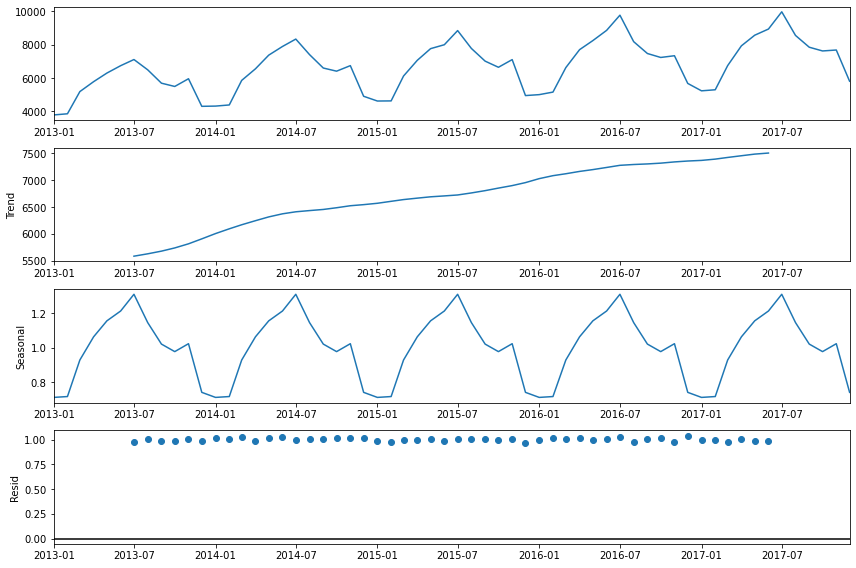

In [87]:
result = seasonal_decompose(data_df, model='multiplicative')
plt.rcParams['figure.figsize'] = [12, 8]
result.plot()
plt.show()